# Steuerungsentwurf

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from IPython.display import display, Image, Latex
from scipy.integrate import solve_ivp

In [2]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

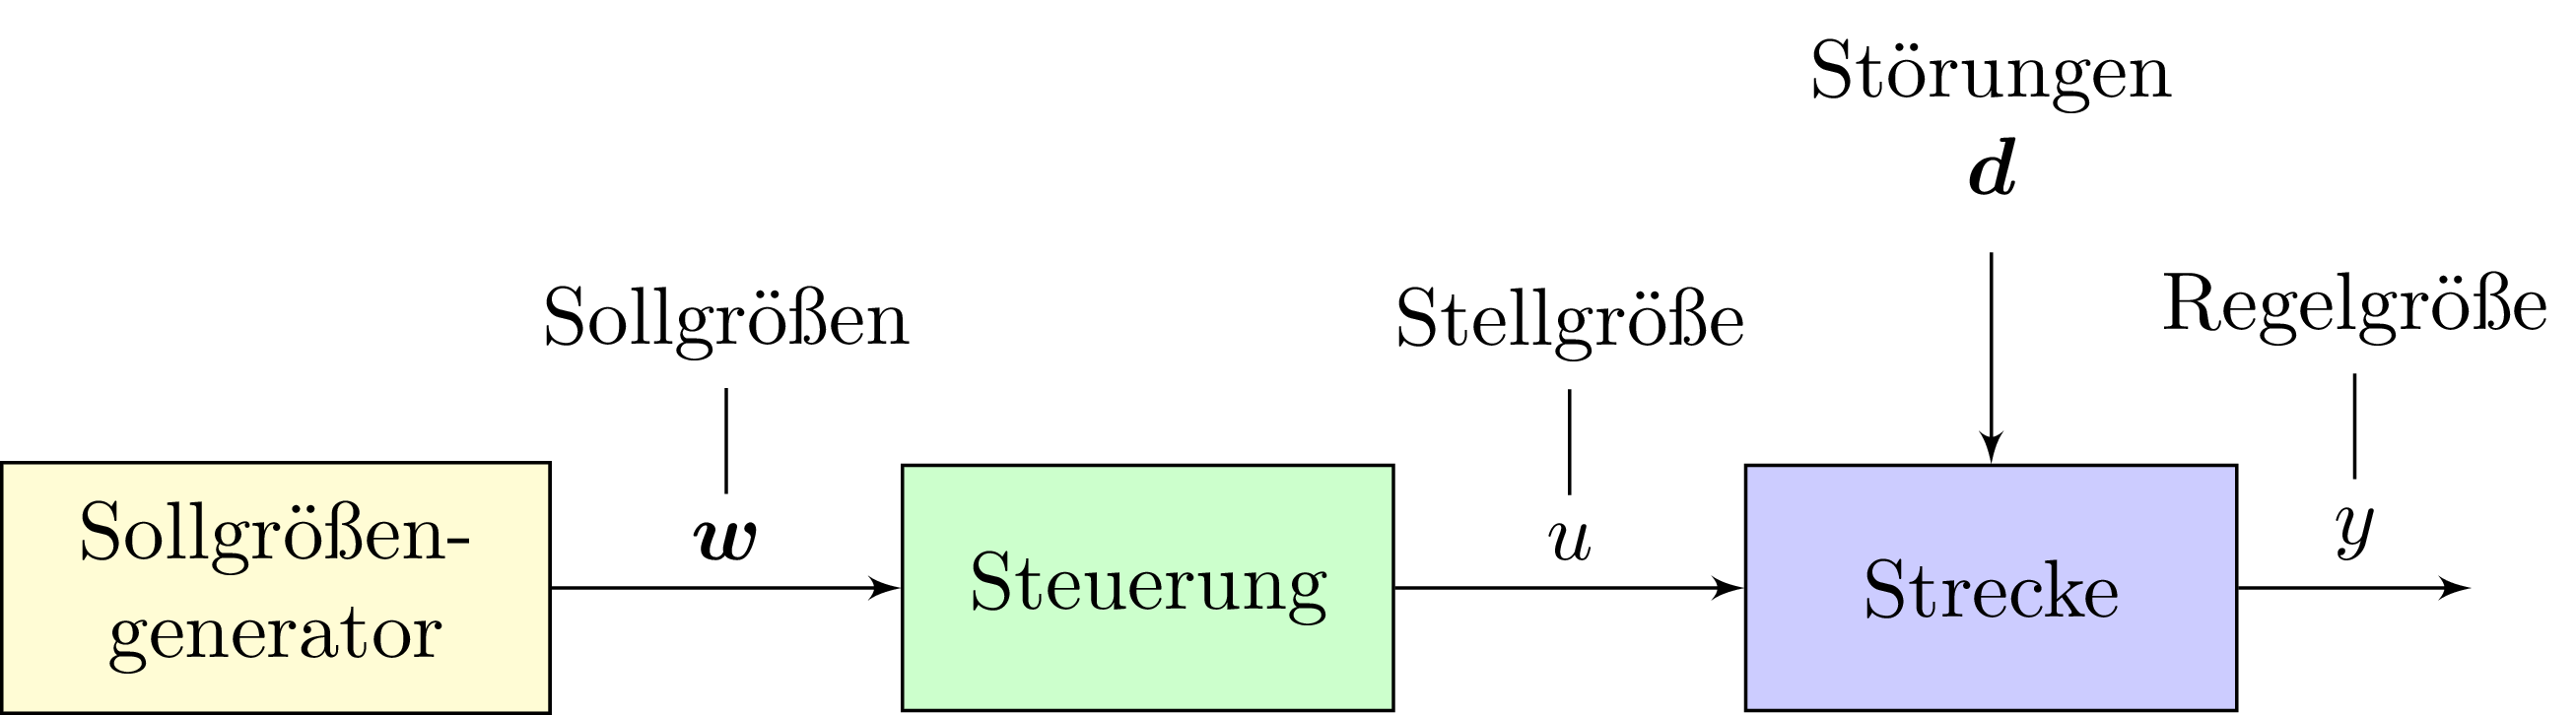

In [3]:
imag = Image("../images/feedForwardGenerator.png", width=600)
display(imag)

Ziel ist der Entwurf einer Steuerung auf Basis des linearisierten Modells des Zweitanksystems
\begin{align*}
    T_1 T_2 \ddot{\tilde{z}}_2(t) + (T_1 + T_2)\dot{\tilde{z}}_2(t) + \tilde{z}_2(t) & = K \tilde{u}_{\mathrm{A}}(t)
\end{align*}
um die Füllstandshöhe des zweiten Tanks von $z_{2,0} = 0\, \mathrm{m}$ auf $z_{2,1} = 0.15\, \mathrm{m}$ mittels der Funktion
\begin{align*}
    z_{2,\mathrm{r}}(t) & = \begin{cases}
         z_{2,0} & t \leq 0 \\
         z_{2,0} + (z_{2,1} - z_{2,0}) \varphi\left(\frac{t}{\Delta t}\right) & 0 < t < \Delta t \\
         z_{2,1} & t \geq \Delta t \\
    \end{cases}
\end{align*}
in der vorgegebenen Zeit $\Delta t = 150\, \mathrm{s}$ zu überführen.
Dazu ist eine $n$-mal stetig differenzierbaren Trajektorie $\tau \mapsto \varphi(\tau)$ zu bestimmen aus der das Referenzeingangssignal $t \mapsto u_{\mathrm{A,r}}(t)$ berechnet werden kann.

### 1. Eintragen der notwendigen Systemparameter

In [4]:
buA = 9
# Physikalisch
KPhy = 0.147763421835044
T1Phy = 34.567259359529
T2Phy = 68.2115206317666
bz2Phy = 0.137092448385557
# Messung
KMessung = 0.05335540886113588
T1Messung = 11.796537856412515
T2Messung = 80.74097989401139
bz2Messung = 0.13238994944989588

### 2. Bestimmung der Trajektorie

In [5]:
# Ordnung des Systems
n = 2
# Grad der Trajektorie
q = 2 * n + 1
# Definition der benötigten Symbole
t, delta, tau, yd0, yd1 = sp.symbols('t \\Delta \\tau y_{d0} y_{d1}')
bc = sp.symbols('c0:%d' % (q + 1))
phi = []

phi.append(sum(bc_*tau**i for i, bc_ in enumerate(bc)))
display(Latex("$\\varphi(\\tau) = {}$".format(sp.latex(phi[0]))))

for i in range(n):
    phi.append(phi[i].diff(tau))
    display(Latex("$\\varphi^{{({})}}(\\tau) = {}$".format(i + 1, sp.latex(phi[i+1]))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [6]:
sys = []
for i in range(n + 1):
    sys.append(phi[i].subs({tau: 0}))
    sys.append(phi[i].subs({tau: 1}))
    if i == 0:
        sys[-1] -= 1
        
res = sp.solve(sys, bc)
bcNum = [list(res.items())[i][1] for i in range(q + 1)]
for i in range(q + 1):
    display(Latex("${} = {}$".format(sp.latex(list(res.items())[i][0]), sp.latex(list(res.items())[i][1]))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [7]:
phiNum = [phi[i].subs(zip(list(bc), bcNum)) for i in range(n + 1)]
for i in range(n + 1):
    display(Latex("$\\varphi^{{({})}}(\\tau) = {}$".format(i, sp.latex(phiNum[i]))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Implementierung der Trajektorie $z_{2,\mathrm{r}}$ und deren Ableitung mit dem Referenzeingang $u_{\mathrm{A,r}}$

In [8]:
dtNum = 150

z20 = 0 - bz2Messung
z21 = 0.15 - bz2Messung

a0 = 1 / (T1Messung * T2Messung)
a1 = (T1Messung + T2Messung) / (T1Messung * T2Messung)
b = KMessung / (T1Messung * T2Messung)
display(Latex("$a_{{0}} = {},\quad a_{{1}} = {},\quad b = {}$".format(sp.latex(a0), sp.latex(a1), sp.latex(b))))

z2r = lambda t: z20 + (z21 - z20) * phiNum[0].subs({tau: t / dtNum}) if 0 <= t <= dtNum else z20 if t < 0 else z21 
dz2r = lambda t: (z21 - z20) * phiNum[1].subs({tau: t / dtNum}) / dtNum if 0 < t < dtNum else 0
ddz2r = lambda t: (z21 - z20) * phiNum[2].subs({tau: t / dtNum}) / dtNum ** 2 if 0 < t < dtNum else 0
uAr = lambda t: 1/ b * (ddz2r(t) + a1 * dz2r(t) + a0 * z2r(t)) + buA

<>:9: SyntaxWarning: invalid escape sequence '\q'
<>:9: SyntaxWarning: invalid escape sequence '\q'
/tmp/ipykernel_400272/3147456250.py:9: SyntaxWarning: invalid escape sequence '\q'
  display(Latex("$a_{{0}} = {},\quad a_{{1}} = {},\quad b = {}$".format(sp.latex(a0), sp.latex(a1), sp.latex(b))))


<IPython.core.display.Latex object>

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_400272/3500430862.py:6: SyntaxWarning: invalid escape sequence '\m'
  axes10.plot(timeDom, [z2r(t) for t in timeDom], label='$z_{\mathrm{2,r}}$', color='C0')
/tmp/ipykernel_400272/3500430862.py:22: SyntaxWarning: invalid escape sequence '\d'
  axes101.plot(timeDom, [dz2r(t) for t in timeDom], label='$\dot{z}_{\mathrm{2,r}}$', color='C1')
/tmp/ipykernel_400272/3500430862.py:28: SyntaxWarning: invalid escape sequence '\d'
  axes102.plot(timeDom, [ddz2r(t) for t in timeDom], label='$\ddot{z}_{\mathrm{2,r}}$', color='C2')
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
f

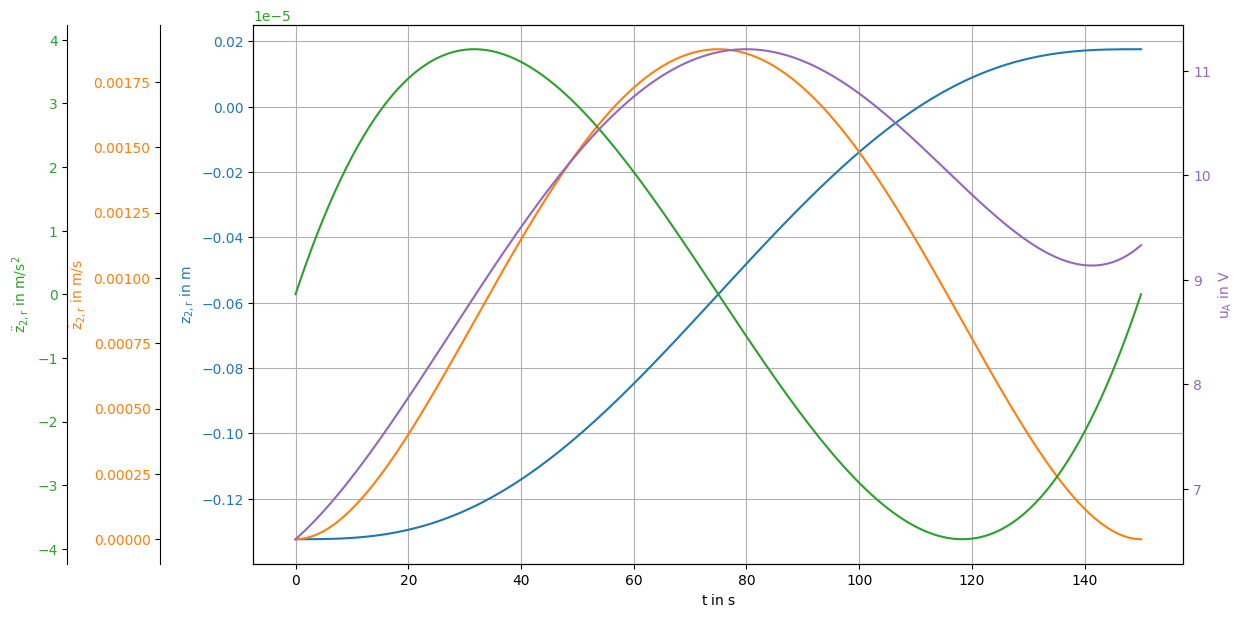

In [9]:
timeDom = np.linspace(0, 150, 151)
plt.close()

fig1, axes10 = plt.subplots(1, 1, figsize=(12,7))

axes10.plot(timeDom, [z2r(t) for t in timeDom], label='$z_{\mathrm{2,r}}$', color='C0')
axes10.tick_params(axis='y', labelcolor='C0')

axes101 = axes10.twinx()
axes102 = axes10.twinx()
axes11 = axes10.twinx() 

axes101.spines["left"].set_position(("axes", -0.1))
axes102.spines["left"].set_position(("axes", -0.2))

make_patch_spines_invisible(axes101)
make_patch_spines_invisible(axes102)

axes101.spines["left"].set_visible(True)
axes101.yaxis.set_label_position('left')
axes101.yaxis.set_ticks_position('left')
axes101.plot(timeDom, [dz2r(t) for t in timeDom], label='$\dot{z}_{\mathrm{2,r}}$', color='C1')
axes101.tick_params(axis='y', labelcolor='C1')

axes102.spines["left"].set_visible(True)
axes102.yaxis.set_label_position('left')
axes102.yaxis.set_ticks_position('left')
axes102.plot(timeDom, [ddz2r(t) for t in timeDom], label='$\ddot{z}_{\mathrm{2,r}}$', color='C2')
axes102.tick_params(axis='y', labelcolor='C2')

axes11.plot(timeDom, [uAr(t) for t in timeDom], color='C4')
axes11.tick_params(axis='y', labelcolor='C4')

axes10.set_ylabel(r'$z_{\mathrm{2,r}}$ in m', color='C0')
axes101.set_ylabel(r'$\dot{z}_{\mathrm{2,r}}$ in m/s', color='C1')
axes102.set_ylabel(r'$\ddot{z}_{\mathrm{2,r}}$ in m/s$^2$', color='C2')
axes11.set_ylabel(r'$u_{\mathrm{A}}$ in V', color='C4')
axes10.set_xlabel(r'$t$ in s')

axes10.grid()
plt.show()

### 3. Vergleich der Steuerung an den Modellen

Definition nichtlineares Modell

In [10]:
def nonLinSys(t, z, uA):
    z1 = z[0]
    z2 = z[1]
        
    hV1 = 0.055
    hV2 = 0.055
    
    dz = np.zeros(2)
    dz[0] = 0.00216625315586689 * (uA(t) - 6.4) - 0.0127646468529449 * np.sqrt(2) * np.sqrt(hV1 + z1)
    dz[1] = 0.0127646468529449 * np.sqrt(2) * np.sqrt(hV1 + z1) - 0.00908683019582126 * np.sqrt(2) * np.sqrt(hV2 + z2)

    return dz

Definition linearisiertes Modell

In [11]:
def linSys(t, x, uA, T1Sys, T2Sys, KSys, buA):
    A = np.array([[0, 1],
                  [-1 / (T1Sys * T2Sys), -(T1Sys + T2Sys) / (T1Sys * T2Sys)]])
    B = np.array([[0],
                  [KSys / (T1Sys * T2Sys)]])
    return A.dot(x) + B.dot(np.array([uA(t) - buA]))

Simulation

In [12]:
timeDom = np.linspace(0, 200, 2000)
z0 = [0, 0]

resPhyLin = solve_ivp(linSys, [timeDom[0], timeDom[-1]], z0 - np.array([bz2Phy, 0]), t_eval=timeDom, args=(uAr, T1Phy, T2Phy, KPhy, buA))
resPhyNichtLin = solve_ivp(nonLinSys, [timeDom[0], timeDom[-1]], z0, t_eval=timeDom, args=(uAr, ))
resMessung = solve_ivp(linSys, [timeDom[0], timeDom[-1]], z0 - np.array([bz2Messung, 0]), t_eval=timeDom, args=(uAr, T1Messung, T2Messung, KMessung, buA))

Visualisierung

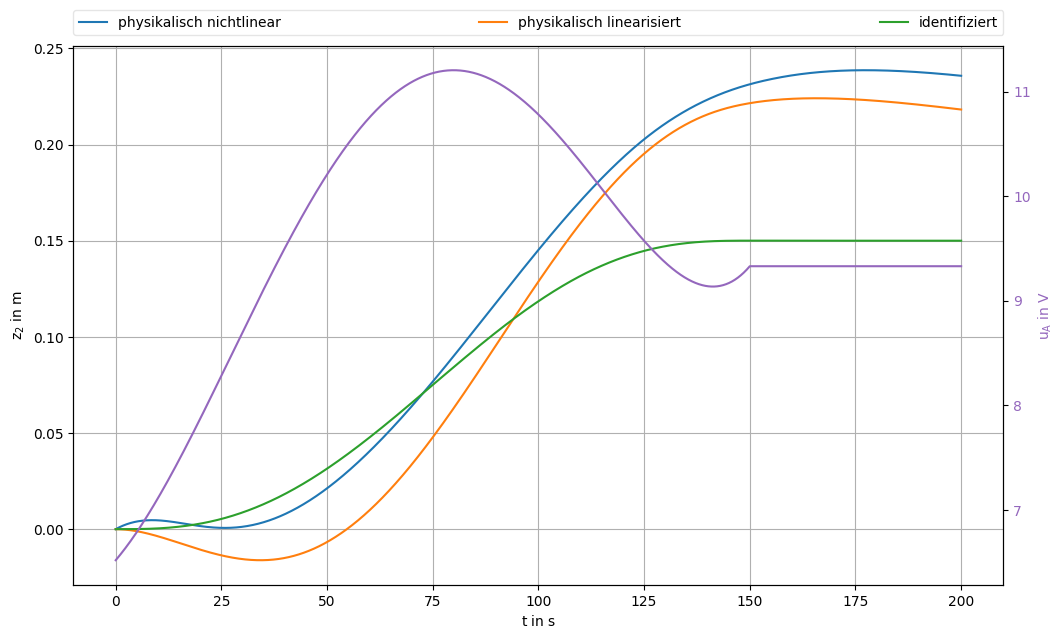

In [13]:
plt.close()

fig1, axes10 = plt.subplots(1, 1, figsize=(12,7))

axes10.plot(timeDom, resPhyNichtLin.y[1], label='physikalisch nichtlinear')
axes10.plot(timeDom, resPhyLin.y[0] + bz2Phy, label='physikalisch linearisiert')
axes10.plot(timeDom, resMessung.y[0] + bz2Messung, label=r'identifiziert')

axes11 = axes10.twinx() 

axes11.plot(timeDom, [uAr(t) for t in timeDom], color='C4')
axes11.tick_params(axis='y', labelcolor='C4')

axes10.set_ylabel(r'$z_2$ in m')
axes11.set_ylabel(r'$u_{\mathrm{A}}$ in V', color='C4')
axes10.set_xlabel(r'$t$ in s')

handlesAx1, labelsAx1 = axes10.get_legend_handles_labels()
axes10.legend([handle for i, handle in enumerate(handlesAx1)],
              [label for i, label in enumerate(labelsAx1)],
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=9, mode="expand", borderaxespad=0., framealpha=0.5)

axes10.grid()
plt.show()